# Verifying Shift Equivariance of CNN

## Checking the Object Detection Functionality

In [20]:
import torch
import torchvision
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple, Union
from collections import OrderedDict

from decomposer import FasterRCNN_Decom
from utils import visualize_detection_result

In [2]:
IMAGE_PATH = './example.jpg'
THRESHOLD = 0.9

In [27]:
# prepare image
img_pil = Image.open(IMAGE_PATH).convert('RGB')
transform = T.Compose([T.ToTensor()])
images = transform(img_pil)
batch_images = [images.cuda()]

shift_x = 64
shift_y = 64

print(f"Image shape: {images.shape}")

# prepare model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
).cuda()
model.eval()

# extract features
targets = None

batch_images, targets = model.transform(batch_images, targets)

print("[Images]")
for batch_image in batch_images.tensors:
    print(batch_image.shape)

raw_features = model.backbone.body(batch_images.tensors)
features = model.backbone.fpn(raw_features)

raw_features_shifted = model.backbone.body(batch_images.tensors[:, :, shift_y:, shift_x:])
features_shifted = model.backbone.fpn(raw_features_shifted)

print("[Raw Features]")
for rfname, raw_feature in raw_features.items():
    print(f"{rfname}: {raw_feature.shape}")
    print(f"{rfname} (shifted): {raw_features_shifted[rfname].shape}")

print("[Features]")
for fname, feature in features.items():
    print(f"{fname}: {feature.shape}")
    print(f"{fname} (shifted): {features_shifted[fname].shape}")



Image shape: torch.Size([3, 480, 854])
[Images]
torch.Size([3, 768, 1344])
[Raw Features]
0: torch.Size([1, 256, 192, 336])
0 (shifted): torch.Size([1, 256, 176, 320])
1: torch.Size([1, 512, 96, 168])
1 (shifted): torch.Size([1, 512, 88, 160])
2: torch.Size([1, 1024, 48, 84])
2 (shifted): torch.Size([1, 1024, 44, 80])
3: torch.Size([1, 2048, 24, 42])
3 (shifted): torch.Size([1, 2048, 22, 40])
[Features]
0: torch.Size([1, 256, 192, 336])
0 (shifted): torch.Size([1, 256, 176, 320])
1: torch.Size([1, 256, 96, 168])
1 (shifted): torch.Size([1, 256, 88, 160])
2: torch.Size([1, 256, 48, 84])
2 (shifted): torch.Size([1, 256, 44, 80])
3: torch.Size([1, 256, 24, 42])
3 (shifted): torch.Size([1, 256, 22, 40])
pool: torch.Size([1, 256, 12, 21])
pool (shifted): torch.Size([1, 256, 11, 20])


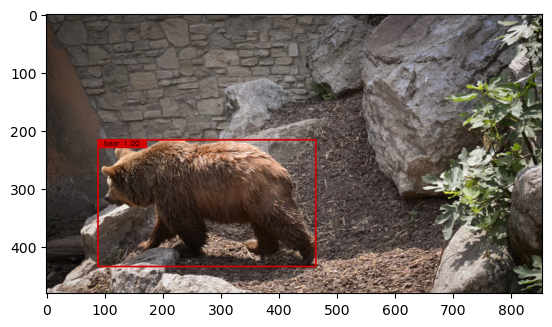

In [25]:
# visualize the object detection result
if isinstance(features, torch.Tensor):
    features = OrderedDict([("0", features)])
proposals, proposal_losses = model.rpn(batch_images, features, targets)
detections, detector_losses = model.roi_heads(features, proposals, batch_images.image_sizes, targets)
detections = model.transform.postprocess(detections, batch_images.image_sizes, original_image_sizes)  # type: ignore[operator]

pred_dict = detections[0]

pred_boxes = pred_dict['boxes']    # [N, 1]
pred_labels = pred_dict['labels']  # [N]
pred_scores = pred_dict['scores']  # [N]

indices = pred_scores >= THRESHOLD
pred_boxes = pred_boxes[indices]
pred_labels = pred_labels[indices]
pred_scores = pred_scores[indices]

im_show = visualize_detection_result(img_pil, pred_boxes, pred_labels, pred_scores)
plt.imshow(im_show)

## Compare Feature Maps

rf shape: torch.Size([1, 256, 192, 336]), rf_shifted shape: torch.Size([1, 256, 176, 320])


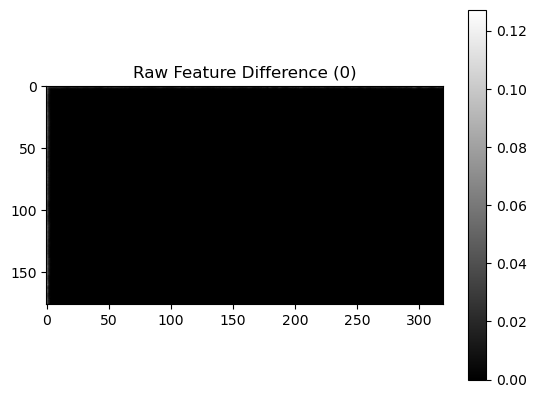

rf shape: torch.Size([1, 512, 96, 168]), rf_shifted shape: torch.Size([1, 512, 88, 160])


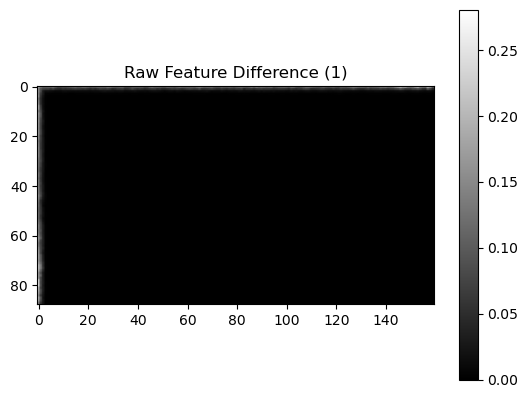

rf shape: torch.Size([1, 1024, 48, 84]), rf_shifted shape: torch.Size([1, 1024, 44, 80])


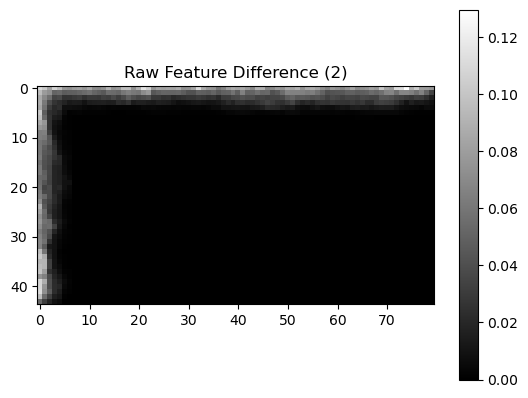

rf shape: torch.Size([1, 2048, 24, 42]), rf_shifted shape: torch.Size([1, 2048, 22, 40])


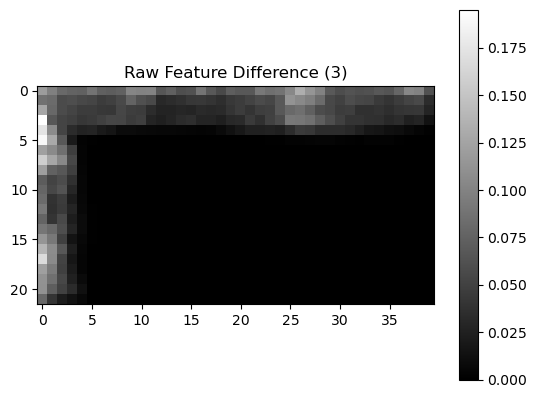

f shape: torch.Size([1, 256, 192, 336]), f_shifted shape: torch.Size([1, 256, 176, 320])


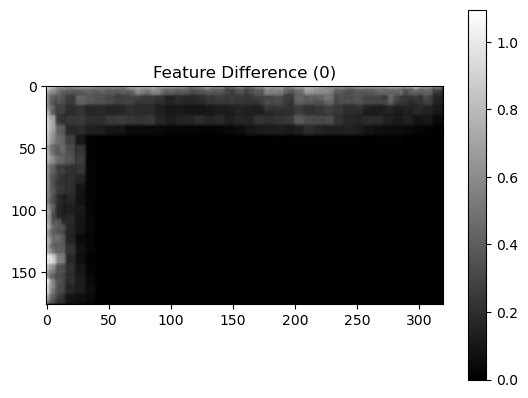

f shape: torch.Size([1, 256, 96, 168]), f_shifted shape: torch.Size([1, 256, 88, 160])


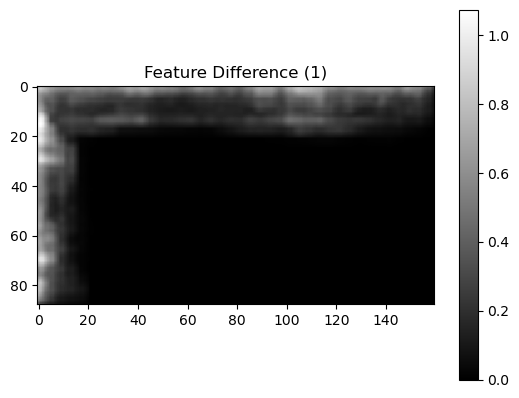

f shape: torch.Size([1, 256, 48, 84]), f_shifted shape: torch.Size([1, 256, 44, 80])


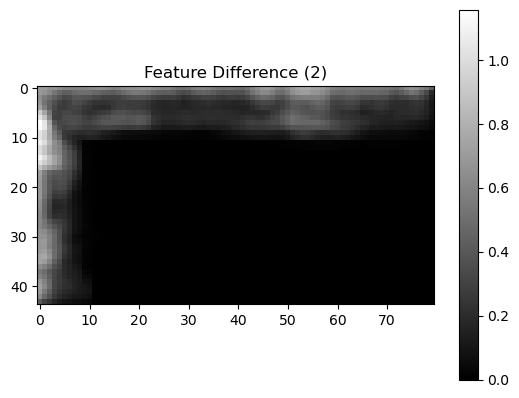

f shape: torch.Size([1, 256, 24, 42]), f_shifted shape: torch.Size([1, 256, 22, 40])


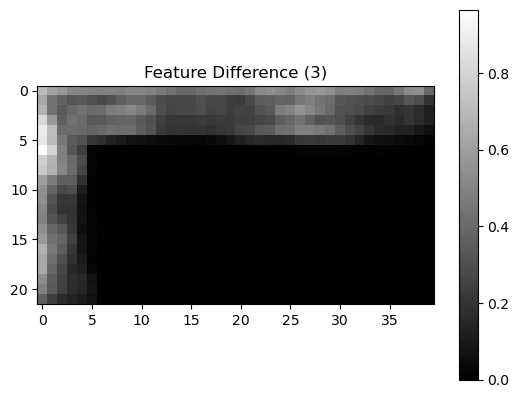

f shape: torch.Size([1, 256, 12, 21]), f_shifted shape: torch.Size([1, 256, 11, 20])


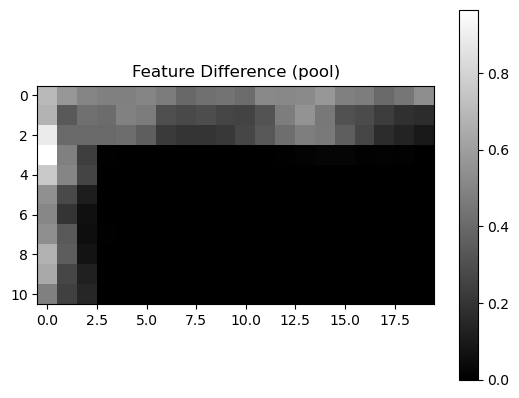

In [37]:
# difference between the features
temp_shift_x, temp_shift_y = shift_x // 4, shift_y // 4

for rfname, raw_feature in raw_features.items():
    print(f"rf shape: {raw_feature.shape}, rf_shifted shape: {raw_features_shifted[rfname].shape}")
    raw_feature_shifted = raw_features_shifted[rfname]
    diff = torch.abs(raw_feature[:, :, temp_shift_y:, temp_shift_x:] - raw_feature_shifted)
    diff = diff.mean(dim=1, keepdim=True)
    diff = diff.squeeze(0).squeeze(0)


    plt.figure()
    plt.imshow(diff.cpu().detach().numpy(), cmap='gray')
    plt.title(f"Raw Feature Difference ({rfname})")
    plt.colorbar()
    plt.show()

    temp_shift_x //= 2
    temp_shift_y //= 2

temp_shift_x, temp_shift_y = shift_x // 4, shift_y // 4

for fname, feature in features.items():
    print(f"f shape: {feature.shape}, f_shifted shape: {features_shifted[fname].shape}")
    feature_shifted = features_shifted[fname]
    diff = torch.abs(feature[:, :, temp_shift_y:, temp_shift_x:] - feature_shifted)
    diff = diff.mean(dim=1, keepdim=True)
    diff = diff.squeeze(0).squeeze(0)

    plt.figure()
    plt.imshow(diff.cpu().detach().numpy(), cmap='gray')
    plt.title(f"Feature Difference ({fname})")
    plt.colorbar()
    plt.show()

    temp_shift_x //= 2
    temp_shift_y //= 2
